In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
# %matplotlib notebook
%matplotlib inline

In [12]:
body_part = "shoulder_left"
file_names = [
    './training_data/TRAINING_DATA.bag']

In [13]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [14]:
abnormal_threshold = 0.5
dataset = []

euler_idxs = ["position_0", "position_1", "position_2"]
action_idxs = ["target_position_0", "target_position_1", "target_position_2"]
magnetic_idxs = [f'{coord}_{id}' for id in range(4) for coord in ['x','y','z']]

for name in file_names:
    df = pd.read_csv(name, header=0)
    
    df['date'] = pd.to_datetime(df.Time, unit='s')
    df.groupby(pd.Grouper(key='date', freq='20L')).mean().interpolate()
    
    # interpolate nan outputs (loss tracking)
    for c in euler_idxs:
        df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
    for c in magnetic_idxs:
        bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
        df.loc[bad_idx, c] = np.nan
        df[c] = df[c].interpolate()
    
    dataset.append(df)

dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 

print(f'{np.sum(dataset_len)} values')
dataset = dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]

euler_set = dataset[:, 12:15]
sensors_set = dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

106956 values
max euler 1.2224556693615332
min euler -2.1933230057373283


In [5]:
data_in_train = NormalizeData(sensors_set)
data_out_train = NormalizeData(euler_set)

## Data plotting

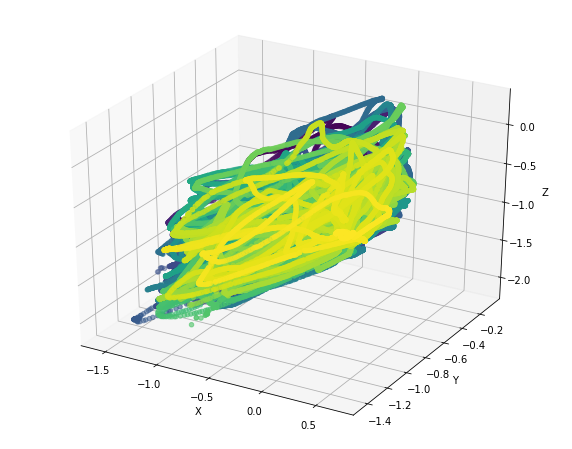

In [6]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(euler_set[:,0], euler_set[:,1], euler_set[:,2], c=np.arange(len(euler_set)))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
    
plt.show()

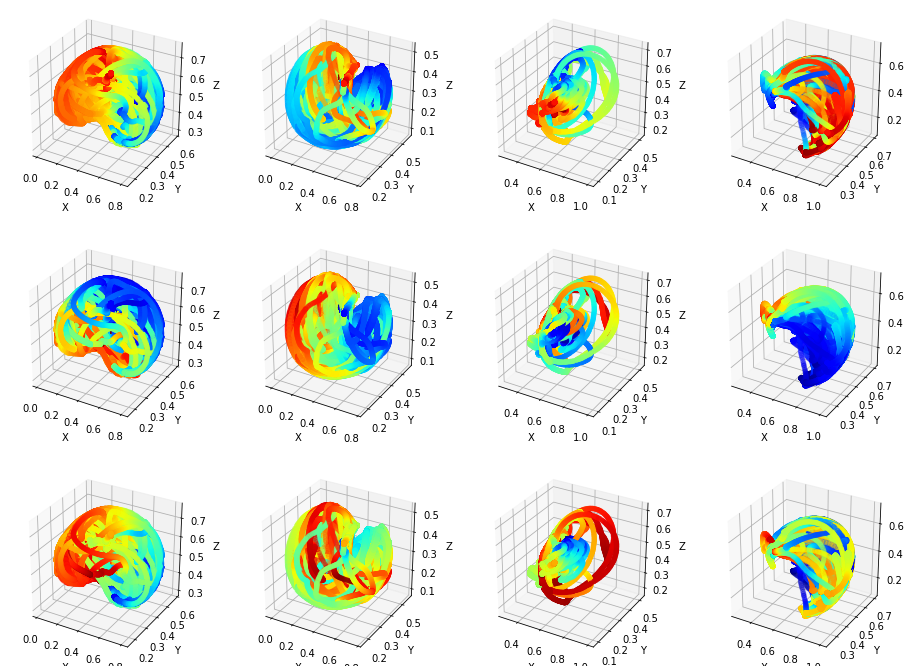

In [7]:
fig = plt.figure(figsize=(16,12))

for j in range(0, 3):
    for i in range(0, 4):
        ax = fig.add_subplot(3, 4, j*4+i+1, projection='3d')
        ax.scatter(data_in_train[:,i*3], data_in_train[:,i*3+1], data_in_train[:,i*3+2], 
                   c=data_out_train[:, j], cmap='jet')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
plt.show()
fig.savefig('./outputs/'+body_part+'_plot.png', dpi=100, bbox_inches='tight')

## Dimension reduction

### PCA

In [8]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_in_train)

In [9]:
pca.singular_values_

array([69.42790743, 63.50597165, 48.73269679])

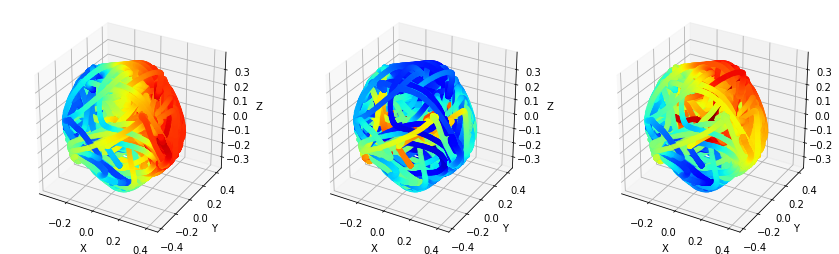

In [10]:
fig = plt.figure(figsize=(20,15))

for j in range(0, 3):
    ax = fig.add_subplot(3, 4, j+1, projection='3d')
    ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], 
               c=data_out_train[:, j], cmap='jet')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
plt.show()
fig.savefig('./outputs/'+body_part+'_pca.png', dpi=100, bbox_inches='tight')